<h2><center>Importation des package</center></h2>
<center>(nombre des lucioles "nl", max bound "MB",
min bound "mb",nombre des variables "nv",..</center>

In [31]:
print("*************************************************** Importation des packages***************************************************")
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dropout
import numpy
from keras.preprocessing import image
from PIL import Image
import numpy as np
import sys
import os
import csv
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from numpy import expand_dims
from tensorflow.python.eager.function import Function
import numpy as np
import math
import operator
import time as time
import psutil
import numpy
import matplotlib.pyplot as plt
print("* list des packages: ")
print("keras,numpy,PIL,SYS,OS,CSV,tensorflow,MATH,OPERATOR,TIME,PSUTIL,matplotlib")

*************************************************** Importation des packages***************************************************
* list des packages: 
keras,numpy,PIL,SYS,OS,CSV,tensorflow,MATH,OPERATOR,TIME,PSUTIL,matplotlib


In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<h2><center>initialisation des paramères</center></h2>
<center>nombre des lucioles , max bound ,min bound,nombre des variables ,..</center>

In [10]:
print("debut.......")

# #DEFINITION OF CNN PARAMETERS
batch_size = 5
kernel_size = (4,)
stride = 1
# #EPOCHS AND FILTERS ARE DEFINED BY PARTICLES
#DEFINITION OF firefly PARAMETERS
numberFirefly = 6
iterations = 4
#
minBound = numpy.ones(2)  # MIN BOUND FOR TWO DIMENSIONS IS 1
maxBound = numpy.ones(2)  # ONLY INITIALIZATION
maxBound[0] = 50 # MAX NUMBER OF FILTERS
maxBound[1] = 500  # MAX NUMBER OF EPOCHS
bounds = (minBound, maxBound)
print("bound:",bounds)
print("****************************************************************************************************************")

debut.......
bound: (array([1., 1.]), array([ 50., 500.]))
****************************************************************************************************************


<h3><center>generation des populations</center></h3>
<center><strong> 1/  génération des positions des lucioles </strong> <br>générer  des lucioles aléatoirement "nl" firefly chaque firefly contient "nv" variables compris entre "MB" et "mb" </center>

In [11]:
print("generation des populations")
from numpy.random import random_sample
def generate_population(population_size, problem_dim, min_bound, max_bound):
    error = 1e-10
    data = (max_bound + error - min_bound) * random_sample((population_size, problem_dim)) + min_bound
    #data[data > max_bound] = max_bound
    return data

fireflies=generate_population(numberFirefly, 2, minBound, maxBound)
fireflies = fireflies.astype(int)
print("population :")
print(fireflies)
print("*******************************************************************************************************************")

generation des populations
population :
[[  4 390]
 [ 22 362]
 [ 48 269]
 [ 25  36]
 [ 14 250]
 [ 34 402]]
*******************************************************************************************************************


# DATA

In [2]:
import pandas as pd
export_dataframe_1 = pd.read_excel('export_dataframe.xlsx')

In [3]:
export_dataframe=export_dataframe_1
export_dataframe=export_dataframe.groupby(pd.Grouper(key='Date Opération', axis=0, freq='D')).sum()
export_dataframe.head(3)

,Dossier,Poids Taxable,Catégorie,Prévision,Réalisation,N° Achat,prev_resultat
Date Opération,,,,,,,
2017-01-02,1.862371e+10,720389.00,3367,10936.146190,10866.671905,2057463002,69.474286
2017-01-03,1.288171e+10,507856.00,1781,10097.422857,10090.737143,1259284920,6.685714
2017-01-04,2.608677e+10,1267171.63,4703,17320.157619,17306.176667,2839801236,13.980952


In [4]:
export_dataframe=export_dataframe.drop(columns=['Dossier', 'Poids Taxable','Catégorie','Prévision','N° Achat','prev_resultat'])

In [5]:
split_date = '2020-12-31'

train = export_dataframe.loc[export_dataframe.index <= split_date]
test = export_dataframe.loc[export_dataframe.index > split_date]
print(f"{len(train)} days of training data \n {len(test)} days of testing data ")

1460 days of training data 
 448 days of testing data 


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataset = export_dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


<center><strong> 2/ genétarion des luminisotés des firefly</strong>  <br> initialiser la luminosité 'I' des chaque firefly généré par le taux de perte de modèle basé sur les paramètre de cette firefly</strong></center> 

In [12]:
print('*******************************************declaration de cnn_covid19**********************************************')
print("cette fonction va entrainer le modèle crée par les nombre des epochs et filters de chaque firefly et retourner le taux"
      "de perte de cette modèle après le test de cette modèle sur un ensemble de test")

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt

def Lstm_optm(epochs, filters,save=False):
    
    #reshape into X=t and Y=t+1
    look_back = filters
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    # create and fit the GRU network
    batch_size = 1
    model = Sequential()
    model.add(GRU(64, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(GRU(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
   
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    rmse= sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    
    return rmse
    

*******************************************declaration de cnn_covid19**********************************************
cette fonction va entrainer le modèle crée par les nombre des epochs et filters de chaque firefly et retourner le tauxde perte de cette modèle après le test de cette modèle sur un ensemble de test


In [13]:
print("******************************************déclaration de optimize CNN****************************************************")
print("cette fonction va avoir une luciole contenant le nombre des epochs et des filters généré après on va calculer l'accuracy"
      "de modèle basé sur cette nombre des epochs et filters (en passant ces paramètre a la fonction CNN_COVID) et finalement on va calculer" 
      "le taux de perte en se basant sur l'accuracy et nombre de filter et des epochs")
def LossCNN(firefly):
    try:
        
        print(firefly)
        #RETRIEVE DIMENSIONS OF PARTICLE
        numberFilters = int(firefly[0]) #FLOAT TO INT
        numberEpochs = int(firefly[1])

        #CALL CNN FUNCTION cnn --> RETURN accuracy
        rmse = Lstm_optm(epochs=numberEpochs, filters=numberFilters)

        #APPLY LOST FUNCTION --> THE MAIN OBJECTIVE IS TO MINIMIZE LOSS --> MAXIMIZE ACCURACY AND AT SAME TIME MINIMIZE THE NUMBER OF EPOCHS
                                #AND FILTERS, TO REDUCE TIME AND COMPUTACIONAL POWER
        
        return rmse

    except:
        raise

******************************************déclaration de optimize CNN****************************************************
cette fonction va avoir une luciole contenant le nombre des epochs et des filters généré après on va calculer l'accuracyde modèle basé sur cette nombre des epochs et filters (en passant ces paramètre a la fonction CNN_COVID) et finalement on va calculerle taux de perte en se basant sur l'accuracy et nombre de filter et des epochs


In [14]:
print("****************************************déclaration au Firefly-Iteration***********************************************")
print("cette fonction va boucler sur le nombre des lucioles générer et pour chaque itération on va faire appel "
      "a la fonction LossCNN qui va retourne le taux de perte de modèle de firefly passé en paramètre")
def FireflyIteration(fireflies):
    try:
        numberFirefly = fireflies.shape[0]
        allLosses = [LossCNN(firefly=fireflies[i])for i in range(numberFirefly)]


        return allLosses#NEED TO RETURN THIS PYSWARMS NEED THIS

    except:
        raise

****************************************déclaration au Firefly-Iteration***********************************************
cette fonction va boucler sur le nombre des lucioles générer et pour chaque itération on va faire appel a la fonction LossCNN qui va retourne le taux de perte de modèle de firefly passé en paramètre


In [16]:
import numpy as np
print("initialisation...............")
allLosses=np.array([])
allLosses=FireflyIteration(fireflies)


initialisation...............
[  4 390]
1273/1273 - 2s - loss: 0.0062
1273/1273 - 2s - loss: 0.0057
1273/1273 - 2s - loss: 0.0055
1273/1273 - 2s - loss: 0.0054
1273/1273 - 3s - loss: 0.0053
1273/1273 - 3s - loss: 0.0051
1273/1273 - 3s - loss: 0.0049
1273/1273 - 2s - loss: 0.0048
1273/1273 - 2s - loss: 0.0047
1273/1273 - 3s - loss: 0.0047
1273/1273 - 3s - loss: 0.0044
1273/1273 - 3s - loss: 0.0042
1273/1273 - 2s - loss: 0.0047
1273/1273 - 2s - loss: 0.0044
1273/1273 - 3s - loss: 0.0040
1273/1273 - 2s - loss: 0.0038
1273/1273 - 2s - loss: 0.0036
1273/1273 - 3s - loss: 0.0038
1273/1273 - 3s - loss: 0.0053
1273/1273 - 2s - loss: 0.0046
1273/1273 - 3s - loss: 0.0046
1273/1273 - 2s - loss: 0.0042
1273/1273 - 2s - loss: 0.0043
1273/1273 - 3s - loss: 0.0042
1273/1273 - 3s - loss: 0.0039
1273/1273 - 3s - loss: 0.0039
1273/1273 - 5s - loss: 0.0038
1273/1273 - 3s - loss: 0.0037
1273/1273 - 3s - loss: 0.0035
1273/1273 - 3s - loss: 0.0034
1273/1273 - 4s - loss: 0.0034
1273/1273 - 3s - loss: 0.0032


1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0014
1273/1273 - 4s - loss: 0.0013
1273/1273 - 3s - loss: 0.0015
1273/1273 - 3s - loss: 0.0013
1273/1273 - 5s - loss: 0.0013
1273/1273 - 4s - loss: 0.0016
1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0016
1273/1273 - 4s - loss: 0.0014
1273/1273 - 4s - loss: 0.0018
1273/1273 - 4s - loss: 0.0017
1273/1273 - 4s - loss: 0.0016
1273/1273 - 4s - loss: 0.0013
1273/1273 - 4s - loss: 0.0014
1273/1273 - 4s - loss: 0.0014
1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0013
1273/1273 - 3s - loss: 0.0015
1273/1273 - 3s - loss: 0.0014
1273/1273 - 3s - loss: 0.0013
1273/1273 - 4s - loss: 0.0012
1273/1273 - 4s - loss: 0.0012
1273/1273 - 3s - loss: 0.0015
1273/1273 - 3s - loss: 0.0012
1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0012
1273/1273 - 3s - loss: 0.0012
1273/1273 - 3s - loss: 0.0013
1273/1273 - 4s - loss: 0.0015
1273/1273 - 4s - loss: 0.0014
1273/1273 - 4s - loss: 0.0014
1273/1273 

1255/1255 - 9s - loss: 6.9738e-04
1255/1255 - 9s - loss: 5.4054e-04
1255/1255 - 10s - loss: 5.7300e-04
1255/1255 - 9s - loss: 7.0591e-04
1255/1255 - 9s - loss: 6.5804e-04
1255/1255 - 9s - loss: 5.9118e-04
1255/1255 - 10s - loss: 7.8042e-04
1255/1255 - 9s - loss: 5.9738e-04
1255/1255 - 9s - loss: 5.4158e-04
1255/1255 - 9s - loss: 6.4447e-04
1255/1255 - 9s - loss: 5.0458e-04
1255/1255 - 9s - loss: 4.9656e-04
1255/1255 - 10s - loss: 6.6696e-04
1255/1255 - 9s - loss: 6.2922e-04
1255/1255 - 10s - loss: 4.4619e-04
1255/1255 - 9s - loss: 5.4711e-04
1255/1255 - 9s - loss: 6.1952e-04
1255/1255 - 9s - loss: 5.3855e-04
1255/1255 - 10s - loss: 5.3719e-04
1255/1255 - 10s - loss: 5.7584e-04
1255/1255 - 9s - loss: 5.7793e-04
1255/1255 - 9s - loss: 5.3529e-04
1255/1255 - 9s - loss: 5.1659e-04
1255/1255 - 9s - loss: 5.2092e-04
1255/1255 - 9s - loss: 5.7455e-04
1255/1255 - 10s - loss: 5.1997e-04
1255/1255 - 9s - loss: 4.5716e-04
1255/1255 - 9s - loss: 4.4219e-04
1255/1255 - 9s - loss: 5.6579e-04
1255/12

1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0025
1229/1229 - 18s - loss: 0.0026
1229/1229 - 18s - loss: 0.0025
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0023
1229/1229 - 18s - loss: 0.0024
1229/1229 - 18s - loss: 0.0050
1229/1229 - 18s - loss: 0.0077
1229/1229 - 18s - loss: 0.0076
1229/1229 - 18s - loss: 0.0075
1229/1229 - 18s - loss: 0.0074
1229/1229 - 18s - loss: 0.0071
1229/1229 - 17s - loss: 0.0070
1229/1229 - 18s - loss: 0.0069
1229/1229 - 18s - loss: 0.0070
1229/1229 - 17s - loss: 0.0063
1229/1229 - 18s - loss: 0.0074
1229/1229 - 18s - loss: 0.0067
1229/1229 - 18s - loss: 0.0059
1229/1229 - 18s - loss: 0.0074
1229/1229 - 18s - loss: 0.0068
1229/1229 - 18s - loss: 0.0069
1229/1229 - 18s - loss: 0.0054
1229/1229 - 18s - loss: 0.0053
1229/1229 - 18s - loss: 0.0044
1229/1229 - 18s - loss: 0.0041
1229/1229 - 18s - loss: 0.0046
1229/122

1252/1252 - 11s - loss: 0.0036
1252/1252 - 11s - loss: 0.0034
1252/1252 - 11s - loss: 0.0032
1252/1252 - 11s - loss: 0.0030
1252/1252 - 11s - loss: 0.0029
1252/1252 - 11s - loss: 0.0028
1252/1252 - 11s - loss: 0.0027
1252/1252 - 12s - loss: 0.0026
1252/1252 - 10s - loss: 0.0026
1252/1252 - 10s - loss: 0.0025
1252/1252 - 13s - loss: 0.0025
1252/1252 - 11s - loss: 0.0025
1252/1252 - 10s - loss: 0.0024
1252/1252 - 10s - loss: 0.0024
1252/1252 - 10s - loss: 0.0024
1252/1252 - 10s - loss: 0.0024
1252/1252 - 12s - loss: 0.0024
1252/1252 - 11s - loss: 0.0024
1252/1252 - 10s - loss: 0.0024
1252/1252 - 12s - loss: 0.0024
1252/1252 - 12s - loss: 0.0024
1252/1252 - 11s - loss: 0.0024
1252/1252 - 12s - loss: 0.0024
1252/1252 - 11s - loss: 0.0024
1252/1252 - 11s - loss: 0.0023
1252/1252 - 12s - loss: 0.0024
1252/1252 - 12s - loss: 0.0023
Train Score: 31401.03 RMSE
Test Score: 62908.85 RMSE
[ 14 250]
1263/1263 - 8s - loss: 0.0052
1263/1263 - 7s - loss: 0.0037
1263/1263 - 6s - loss: 0.0037
1263/1263 

1263/1263 - 7s - loss: 4.2839e-04
1263/1263 - 8s - loss: 4.8041e-04
1263/1263 - 7s - loss: 3.6770e-04
1263/1263 - 8s - loss: 3.8597e-04
1263/1263 - 7s - loss: 3.8898e-04
1263/1263 - 7s - loss: 4.4854e-04
1263/1263 - 7s - loss: 3.9049e-04
1263/1263 - 7s - loss: 3.3737e-04
1263/1263 - 7s - loss: 4.2260e-04
1263/1263 - 7s - loss: 4.4814e-04
1263/1263 - 7s - loss: 4.1383e-04
1263/1263 - 7s - loss: 3.0251e-04
1263/1263 - 7s - loss: 3.7022e-04
1263/1263 - 7s - loss: 4.2314e-04
1263/1263 - 7s - loss: 3.8455e-04
1263/1263 - 7s - loss: 3.4241e-04
1263/1263 - 8s - loss: 3.0401e-04
1263/1263 - 7s - loss: 4.6494e-04
1263/1263 - 7s - loss: 3.3148e-04
1263/1263 - 7s - loss: 2.9168e-04
1263/1263 - 7s - loss: 3.0970e-04
1263/1263 - 7s - loss: 3.1642e-04
Train Score: 18847.86 RMSE
Test Score: 57317.65 RMSE
[ 34 402]
1243/1243 - 15s - loss: 0.0061
1243/1243 - 15s - loss: 0.0049
1243/1243 - 14s - loss: 0.0037
1243/1243 - 14s - loss: 0.0034
1243/1243 - 15s - loss: 0.0031
1243/1243 - 14s - loss: 0.0029
124

1243/1243 - 13s - loss: 4.3116e-04
1243/1243 - 14s - loss: 3.9816e-04
1243/1243 - 13s - loss: 4.2297e-04
1243/1243 - 13s - loss: 4.1791e-04
1243/1243 - 14s - loss: 4.2387e-04
1243/1243 - 13s - loss: 3.4694e-04
1243/1243 - 13s - loss: 3.3835e-04
1243/1243 - 14s - loss: 3.6839e-04
1243/1243 - 14s - loss: 3.9128e-04
1243/1243 - 13s - loss: 3.5574e-04
1243/1243 - 13s - loss: 3.3831e-04
1243/1243 - 13s - loss: 3.2612e-04
1243/1243 - 13s - loss: 3.8297e-04
1243/1243 - 13s - loss: 4.9567e-04
1243/1243 - 13s - loss: 3.9619e-04
1243/1243 - 13s - loss: 3.1889e-04
1243/1243 - 14s - loss: 2.6842e-04
1243/1243 - 16s - loss: 3.8688e-04
1243/1243 - 13s - loss: 3.8071e-04
1243/1243 - 13s - loss: 2.9593e-04
1243/1243 - 13s - loss: 3.0780e-04
1243/1243 - 13s - loss: 3.6276e-04
1243/1243 - 14s - loss: 3.9609e-04
1243/1243 - 13s - loss: 3.5936e-04
1243/1243 - 13s - loss: 2.8300e-04
1243/1243 - 13s - loss: 3.8005e-04
1243/1243 - 15s - loss: 3.6112e-04
1243/1243 - 13s - loss: 3.2180e-04
1243/1243 - 13s - lo

In [16]:
print("fin de initialisation des paramère")

fin de initialisation des paramère


In [51]:
print("************************************  voila les paramètre (loss) des firefly a initialisé**********************")
print(allLosses)
for i in range(numberFirefly):
    print("firefly [ epochs = ",fireflies[i][1],", filter = " ,fireflies[i][0], "] ==> Loss (lumunisoté :)",allLosses[i]) 

************************************  voila les paramètre (loss) des firefly a initialisé**********************
[66802.42931089646, 59378.87774118187, 59790.176634135, 62908.85292013904, 57317.65244587229, 60558.02580457171]
firefly [ epochs =  390 , filter =  4 ] ==> Loss (lumunisoté :) 66802.42931089646
firefly [ epochs =  362 , filter =  22 ] ==> Loss (lumunisoté :) 59378.87774118187
firefly [ epochs =  269 , filter =  48 ] ==> Loss (lumunisoté :) 59790.176634135
firefly [ epochs =  36 , filter =  25 ] ==> Loss (lumunisoté :) 62908.85292013904
firefly [ epochs =  250 , filter =  14 ] ==> Loss (lumunisoté :) 57317.65244587229
firefly [ epochs =  402 , filter =  34 ] ==> Loss (lumunisoté :) 60558.02580457171


<h3><center>le lancement de l'optimisation A l'aide de l'algorithme Firefly</center></h3>

from IPython.display import Image
Image("DPL3.png",width=1000)

In [52]:
print("********* class Firefly ********")

class Firefly:

    def __init__(self, position,brightness,function):
        self.func = function                         # Choose the benchmark algorithm to run
        self.position = position
        self.brightness = brightness
        #self.update_brightness()

    # the best fit is 0
    def update_brightness(self):
        self.brightness = -self.func(self.position)
        
       

********* class Firefly ********


In [53]:
class FireflyOptimizer:

    def __init__(self, obj, **kwargs):
        self.population_size = int(kwargs.get('population_size', 4))
        self.problem_dim = kwargs.get('problem_dim', 2)
        self.min_bound = kwargs.get('min_bound', 1)
        self.max_bound = kwargs.get('max_bound', 30)
        self.generations = kwargs.get('generations', 2)
        self.population = self._population(self.population_size, self.problem_dim, self.min_bound, self.max_bound)
        self.gamma = kwargs.get('gamma', 0.95)  # absorption coefficient
        self.alpha = kwargs.get('alpha', 0.25)  # randomness [0,1]
        self.beta_init = kwargs.get('beta_init', 1)
        self.beta_min = kwargs.get('beta_min', 0.2)
        self.optimization_benchmark = obj
        self.dtime = 0

    @staticmethod
    def _population(population_size, problem_dim, min_bound, max_bound):
        population = []
        for i in range(population_size):
            population.append(Firefly(problem_dim, min_bound, max_bound))
        return population

    def step(self):
        self.population.sort(key=operator.attrgetter('brightness'), reverse=True)
        self._modify_alpha()
        tmp_population = self.population
        for i in range(self.population_size):
            for j in range(self.population_size):
                if self.population[i].brightness > tmp_population[j].brightness:
                    r = math.sqrt(np.sum((self.population[i].position - tmp_population[j].position) ** 2))
                    beta = (self.beta_init - self.beta_min) * math.exp(-self.gamma * r ** 2) + self.beta_min
                    tmp = self.alpha * (np.random.random_sample((1, self.problem_dim))[0] - 0.5) * (
                            self.max_bound - self.min_bound)
                    self.population[j].position = self.check_position(
                        self.population[i].position * (1 - beta) + tmp_population[
                            j].position * beta + tmp)
                    self.population[j].update_brightness()

        # Changing the position of Brightness so the population will shift to other locations

        # self.population[0].position = generate_population(1, self.problem_dim, self.min_bound, self.max_bound)[0]
        # self.population[0].update_brightness()

    # Best placement for each Generation
    def run_firefly(self, population):
        self.population = population
        start = time.time()

        self.res = {}
        for t in range(self.generations):
            self.res[t] = ('Generation %s, best fitness %s' % (t, self.population[0].brightness))
            self.step()
        end = time.time()
        self.dtime = end - start
        self.dtime = float(str(end - start)[:4])
        # """ psg.popup_scrolled('FA Results\n',
        #                  self.res,
        #                 '\nAlgorithm run time: ', self.dtime,
        #                '\nAverage CPU usage: ', psutil.cpu_percent(), size=[50, 30])"""

        self.population.sort(key=operator.attrgetter('brightness'), reverse=True)
        return self.population[0].brightness, self.population[0].position
    def check_position(self, position):
        position[position > self.max_bound] = self.max_bound
        position[position < self.min_bound] = self.min_bound
        return position

    def _modify_alpha(self):
        delta = 1 - (10 ** (-4) / 0.9) ** (1 / self.generations)
        self.alpha = (1 - delta) * self.alpha

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def Lstm_firefly(firefly):
    print("la fonction objective de l'algorithme de firefly va avoir une luciole en paramère et"
          "retourne le taux de perte de modèle basé sur les paramètre de cette luciole")
    epochs=int(firefly[1])
    filters=int(firefly[0])
    #x_test,y_test=generate_x_test()
    print("nbr epoch",epochs)
    print("nbr filter",filters)
    
    #reshape into X=t and Y=t+1
    look_back = filters
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    batch_size = 1
    model = Sequential()
    model.add(GRU(64, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(GRU(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
   
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    rmse= sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (rmse))
    
    return rmse


In [55]:
print("creation des firefly....;")
population = [Firefly(fireflies[i],allLosses[i],Lstm_firefly)for i in range(len(fireflies))]

creation des firefly....;


In [56]:
print("lancement algorithme de firefly..........")
print("l'algorithme peut prendre un peu de temps merci de patienter")
optimizer=FireflyOptimizer(Lstm_firefly)
brightness,position = optimizer.run_firefly(population)

lancement algorithme de firefly..........
l'algorithme peut prendre un peu de temps merci de patienter
la fonction objective de l'algorithme de firefly va avoir une luciole en paramère etretourne le taux de perte de modèle basé sur les paramètre de cette luciole
nbr epoch 30
nbr filter 8
1269/1269 - 3s - loss: 0.0054
1269/1269 - 3s - loss: 0.0045
1269/1269 - 3s - loss: 0.0041
1269/1269 - 3s - loss: 0.0039
1269/1269 - 3s - loss: 0.0036
1269/1269 - 3s - loss: 0.0034
1269/1269 - 4s - loss: 0.0033
1269/1269 - 4s - loss: 0.0031
1269/1269 - 5s - loss: 0.0030
1269/1269 - 5s - loss: 0.0029
1269/1269 - 4s - loss: 0.0029
1269/1269 - 4s - loss: 0.0029
1269/1269 - 5s - loss: 0.0028
1269/1269 - 4s - loss: 0.0028
1269/1269 - 4s - loss: 0.0028
1269/1269 - 4s - loss: 0.0027
1269/1269 - 4s - loss: 0.0026
1269/1269 - 4s - loss: 0.0026
1269/1269 - 4s - loss: 0.0026
1269/1269 - 4s - loss: 0.0026
1269/1269 - 4s - loss: 0.0025
1269/1269 - 4s - loss: 0.0025
1269/1269 - 4s - loss: 0.0025
1269/1269 - 4s - loss

1268/1268 - 10s - loss: 0.0042
1268/1268 - 10s - loss: 0.0039
1268/1268 - 10s - loss: 0.0037
1268/1268 - 10s - loss: 0.0035
1268/1268 - 10s - loss: 0.0032
1268/1268 - 10s - loss: 0.0031
1268/1268 - 9s - loss: 0.0031
1268/1268 - 10s - loss: 0.0030
1268/1268 - 10s - loss: 0.0029
1268/1268 - 10s - loss: 0.0029
1268/1268 - 10s - loss: 0.0029
1268/1268 - 10s - loss: 0.0028
1268/1268 - 10s - loss: 0.0028
1268/1268 - 10s - loss: 0.0027
1268/1268 - 10s - loss: 0.0026
1268/1268 - 10s - loss: 0.0026
1268/1268 - 10s - loss: 0.0027
1268/1268 - 10s - loss: 0.0026
1268/1268 - 10s - loss: 0.0026
1268/1268 - 10s - loss: 0.0025
1268/1268 - 9s - loss: 0.0025
1268/1268 - 10s - loss: 0.0025
1268/1268 - 10s - loss: 0.0024
1268/1268 - 10s - loss: 0.0024
1268/1268 - 10s - loss: 0.0024
1268/1268 - 10s - loss: 0.0024
1268/1268 - 10s - loss: 0.0024
1268/1268 - 10s - loss: 0.0024
Train Score: 31583.76 RMSE
Test Score: 61149.57 RMSE
la fonction objective de l'algorithme de firefly va avoir une luciole en paramère

1270/1270 - 9s - loss: 0.0029
1270/1270 - 8s - loss: 0.0028
1270/1270 - 9s - loss: 0.0028
1270/1270 - 8s - loss: 0.0027
1270/1270 - 9s - loss: 0.0027
1270/1270 - 9s - loss: 0.0027
1270/1270 - 9s - loss: 0.0027
1270/1270 - 8s - loss: 0.0027
1270/1270 - 9s - loss: 0.0026
1270/1270 - 8s - loss: 0.0026
1270/1270 - 9s - loss: 0.0027
1270/1270 - 9s - loss: 0.0027
1270/1270 - 8s - loss: 0.0028
1270/1270 - 9s - loss: 0.0027
1270/1270 - 8s - loss: 0.0027
1270/1270 - 9s - loss: 0.0027
1270/1270 - 9s - loss: 0.0026
1270/1270 - 9s - loss: 0.0026
1270/1270 - 8s - loss: 0.0026
Train Score: 36410.20 RMSE
Test Score: 65983.00 RMSE


In [57]:
print("l'alghoritme a bien terminé et trouvé la bonne ruesultat")
print("**********************************best parametre :**********************************")
print(brightness,position)

l'alghoritme a bien terminé et trouvé la bonne ruesultat
**********************************best parametre :**********************************
66802.42931089646 [  4 390]


In [58]:
def Lstm_firefly1(firefly):
    print("la fonction objective de l'algorithme de firefly va avoir une luciole en paramère et"
          "retourne le taux de perte de modèle basé sur les paramètre de cette luciole")
    epochs=int(firefly[1])
    filters=int(firefly[0])
    #x_test,y_test=generate_x_test()
    look_back = filters
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    batch_size = 1
    model = Sequential()
    model.add(GRU(64, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(GRU(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
   
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    rmse= sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    
    return model,rmse

In [59]:
print("Fiiiiiiiiiiiiiiiiiiiiiiinnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn")
print("lancement d'entrainnement de modèle terminale  en utilisant les meilleur hyperparamètre")
print("..................")
print("on commmence..................")
model,rmse=Lstm_firefly1(position)

Fiiiiiiiiiiiiiiiiiiiiiiinnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
lancement d'entrainnement de modèle terminale  en utilisant les meilleur hyperparamètre
..................
on commmence..................
la fonction objective de l'algorithme de firefly va avoir une luciole en paramère etretourne le taux de perte de modèle basé sur les paramètre de cette luciole
1273/1273 - 7s - loss: 0.0063
1273/1273 - 7s - loss: 0.0057
1273/1273 - 7s - loss: 0.0055
1273/1273 - 7s - loss: 0.0054
1273/1273 - 8s - loss: 0.0054
1273/1273 - 7s - loss: 0.0053
1273/1273 - 6s - loss: 0.0052
1273/1273 - 6s - loss: 0.0051
1273/1273 - 7s - loss: 0.0053
1273/1273 - 6s - loss: 0.0077
1273/1273 - 6s - loss: 0.0058
1273/1273 - 6s - loss: 0.0047
1273/1273 - 6s - loss: 0.0041
1273/1273 - 6s - loss: 0.0041
1273/1273 - 6s - loss: 0.0045
1273/1273 - 6s - loss: 0.0039
1273/1273 - 6s - loss: 0.0043
1273/1273 - 6s - loss: 0.0038
1273/1273 - 6s - loss: 0.0036
1273/1273 - 6s - loss: 0.0044
1273/1273 - 6s - loss: 0.0040
1273/1273 - 6s

1273/1273 - 4s - loss: 0.0017
1273/1273 - 4s - loss: 0.0019
1273/1273 - 4s - loss: 0.0018
1273/1273 - 4s - loss: 0.0016
1273/1273 - 4s - loss: 0.0022
1273/1273 - 5s - loss: 0.0018
1273/1273 - 6s - loss: 0.0017
1273/1273 - 6s - loss: 0.0017
1273/1273 - 7s - loss: 0.0019
1273/1273 - 7s - loss: 0.0020
1273/1273 - 6s - loss: 0.0017
1273/1273 - 7s - loss: 0.0020
1273/1273 - 6s - loss: 0.0019
1273/1273 - 6s - loss: 0.0021
1273/1273 - 6s - loss: 0.0016
1273/1273 - 6s - loss: 0.0018
1273/1273 - 6s - loss: 0.0018
1273/1273 - 6s - loss: 0.0017
1273/1273 - 6s - loss: 0.0019
1273/1273 - 6s - loss: 0.0021
1273/1273 - 6s - loss: 0.0018
1273/1273 - 7s - loss: 0.0019
1273/1273 - 6s - loss: 0.0016
1273/1273 - 6s - loss: 0.0020
1273/1273 - 6s - loss: 0.0018
1273/1273 - 6s - loss: 0.0020
1273/1273 - 6s - loss: 0.0019
1273/1273 - 6s - loss: 0.0016
1273/1273 - 6s - loss: 0.0019
1273/1273 - 6s - loss: 0.0018
1273/1273 - 6s - loss: 0.0016
1273/1273 - 6s - loss: 0.0017
1273/1273 - 6s - loss: 0.0015
1273/1273 

In [60]:
model.save('mo_GRU.h5')

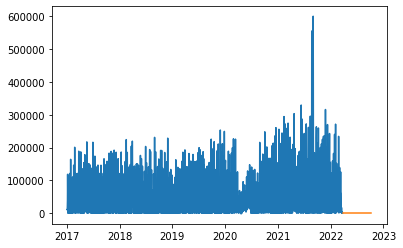

In [72]:
def predict(num_prediction, model):
    look_back=100
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = export_dataframe.index[-1]
    prediction_dates = pd.date_range(last_date , periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 200
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
prevision=scaler.inverse_transform(forecast.reshape(-1, 1))

plt.plot(export_dataframe.index,export_dataframe.Réalisation)
plt.plot(forecast_dates,forecast )

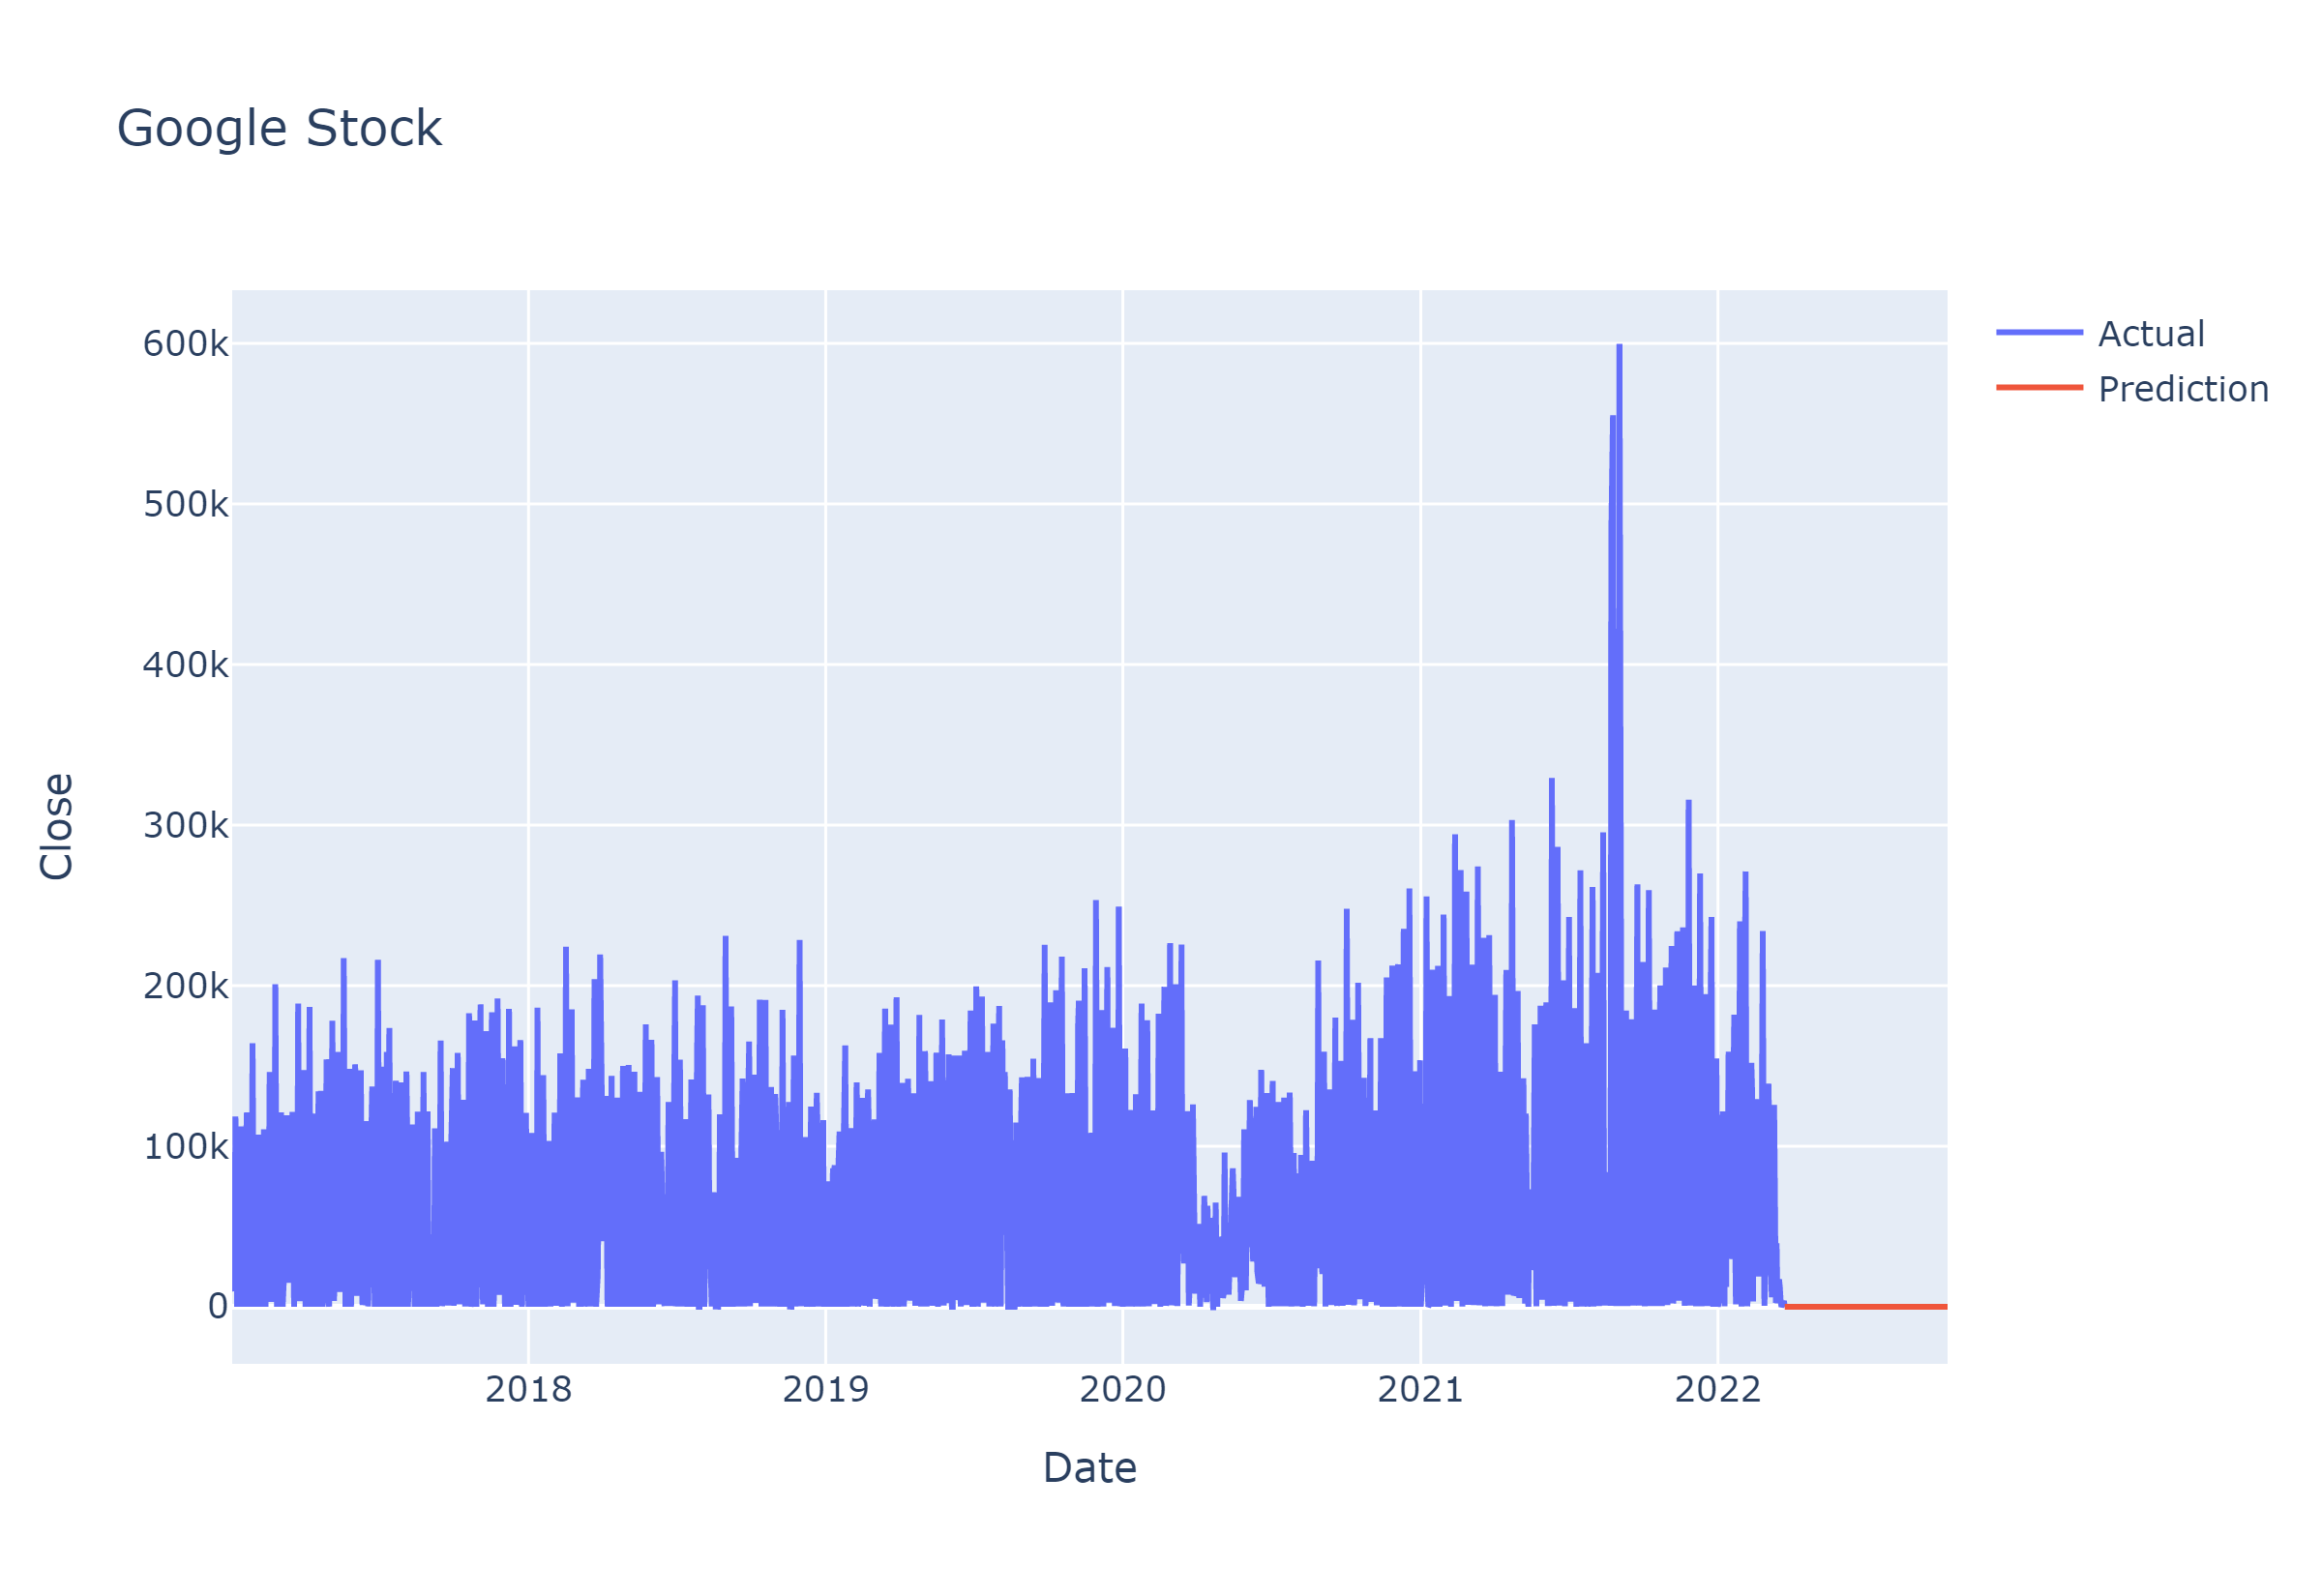

In [68]:
import plotly.graph_objs as go
from IPython.display import Image

trace1 = go.Scatter(
    y = export_dataframe.Réalisation,
    x = export_dataframe.index,
    mode = 'lines',
    name = 'Actual'
)
trace2 = go.Scatter(
    y = forecast,
    x = forecast_dates,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
img_bytes = fig.to_image(format="png", width=800, height=550, scale=3)
Image(img_bytes)